In [1]:
import numpy as np

# Dataset: 'python-algorithms' git repo
base_dataset = open("../data/requests.txt").read()

# Get original character set and create encode/decode functions
chars = sorted(list(set(base_dataset)))

In [2]:
# string-to-integer mapping
stoi = {char: i for i, char in enumerate(chars)}
# integer-to-string mapping  
itos = {i: char for i, char in enumerate(chars)}

# lookup functions for the mappings
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Filter new text to only include original characters
def filter_text(text, allowed_chars):
    return ''.join(char for char in text if char in allowed_chars)

In [3]:
# Load and filter new dataset
text = open("../data/python_fundamentals.txt").read()
filtered_text = filter_text(text, set(chars))  # Convert to set for faster lookup

# Use filtered text for training
data = np.array(encode(filtered_text))

In [4]:
# Max input sequence length
max_seq_len = 1000

n_embd = 64

In [5]:
def cross_entropy_loss(y_pred, y_true):

    # Add a small epsilon to the prediction to avoid log(0), which is undefined.
    epsilon = 1e-6
    
    # cross-entropy formula
    loss = -np.sum(y_true * np.log(y_pred + epsilon))

    return loss


In [6]:
# This class allows for the requires grad variable 
class Parameter:
    def __init__(self, weights, requires_grad=True):
        
        self.data = weights
        self.requires_grad = requires_grad
        self.grad = np.zeros_like(weights)

    def __repr__(self):
        return f"Parameter with data shape {self.data.shape}"

    def __isub__(self, other):
        self.data -= other 

    def zerograds(self):
        if self.requires_grad:
             self.grad = np.zeros_like(self.data)
       

In [7]:
class self_attention_block:
    def __init__(self, W_query, W_key, W_value):
        
        self.W_query = W_query 
        self.W_key = W_key 
        self.W_value = W_value

        self.cache = {}

        
    def forward(self, x):

        self.cache['x'] = x

        B, T, n_embd = x.shape

        # Check if is LoRA layer
        if hasattr(self.W_query, 'forward'):
            queries = self.W_query.forward(x)
        else:
            queries = x @ self.W_query.data

        if hasattr(self.W_key, 'forward'):
            keys = self.W_key.forward(x)
        else:
            keys = x @ self.W_key.data

        if hasattr(self.W_value, 'forward'):
            values = self.W_value.forward(x)
        else:
            values = x @ self.W_value.data

            
        self.cache['queries'] = queries  
        self.cache['keys'] = keys
        self.cache['values'] = values

        # Make key query attention pattern
        attention_scores = (queries @ keys.transpose(0, 2, 1)) / np.sqrt(keys.shape[-1])
        self.cache['attention_scores'] = attention_scores
        
        # Create mask once
        if not hasattr(self, '_mask') or self._mask.shape != (T, T):
            self._mask = np.triu(np.ones((T, T)), k=1).astype(bool)
        
        # Apply mask more efficiently
        attention_scores_masked = attention_scores.copy()
        for b in range(B):  # Apply mask to each batch
            attention_scores_masked[b, self._mask] = -np.inf
        
        # softmax
        stable_scores = attention_scores_masked - np.max(attention_scores_masked, axis=-1, keepdims=True)
        attention_weights = np.exp(stable_scores) / np.sum(np.exp(stable_scores), axis=-1, keepdims=True)
        self.cache['attn_weights'] = attention_weights
        
        # final output: attended inputs
        output = attention_weights @ values  # (B, T, n_embd)

        return output
        
    def backward(self, d_output):

        # Check if is LoRA layer
        if hasattr(self.W_query, 'forward'):
            self.W_query.lora_A.zerograds()
            self.W_query.lora_B.zerograds()
        else:
            self.W_query.zerograds()
        if hasattr(self.W_key, 'forward'):
            self.W_key.lora_A.zerograds()
            self.W_key.lora_B.zerograds()
        else:
            self.W_key.zerograds()
        if hasattr(self.W_value, 'forward'):
            self.W_value.lora_A.zerograds()
            self.W_value.lora_B.zerograds()
        else:
            self.W_value.zerograds()

        # Gradient through: output = attention_weights @ values
        d_attention_weights = d_output @ self.cache['values'].transpose(0, 2, 1)
        d_values = self.cache['attn_weights'].transpose(0, 2, 1) @ d_output  

        # Apply jacobian to backprop through the softmax function
        d_attention_scores = self.cache['attn_weights'] * (d_attention_weights - np.sum(d_attention_weights * self.cache['attn_weights'], axis=-1, keepdims=True))

        # Scale factor
        scale = 1.0 / np.sqrt(self.cache['keys'].shape[-1])
        
        # Gradient through scaling
        d_attention_scores_scaled = d_attention_scores * scale
        
        # Gradient through: queries @ keys.transpose(0, 2, 1)
        d_queries = d_attention_scores_scaled @ self.cache['keys']
        d_keys = d_attention_scores_scaled.transpose(0, 2, 1) @ self.cache['queries']

        if hasattr(self.W_query, 'backward'):
            d_x_from_queries = self.W_query.backward(d_queries, self.cache['x'])
        else:
            W_query_grad, d_x_from_queries = self.linear_backward(d_queries, self.W_query.data, self.cache['x'])

            if self.W_query.requires_grad:
                self.W_query.grad = W_query_grad
        if hasattr(self.W_key, 'backward'):
            d_x_from_keys = self.W_key.backward(d_keys, self.cache['x'])
        else:
            W_key_grad, d_x_from_keys = self.linear_backward(d_keys, self.W_key.data, self.cache['x'])

            if self.W_key.requires_grad:
                self.W_key.grad = W_key_grad
        if hasattr(self.W_value, 'backward'):
            d_x_from_values = self.W_value.backward(d_values, self.cache['x'])
        else:
            W_value_grad, d_x_from_values = self.linear_backward(d_values, self.W_value.data, self.cache['x'])
            
            if self.W_value.requires_grad:
                self.W_value.grad = W_value_grad
        
        # Sum gradients from all three paths
        d_x = d_x_from_queries + d_x_from_keys + d_x_from_values
        return d_x

    @staticmethod
    def linear_backward(d_output, W, x_from_cache):
        d_x = d_output @ W.T
        x_reshaped, dy_reshaped = x_from_cache.reshape(-1, x_from_cache.shape[-1]), d_output.reshape(-1, d_output.shape[-1])
        d_W = x_reshaped.T @ dy_reshaped
        return d_W, d_x


    def optimizer (self, learning_rate):
        if hasattr(self.W_query, 'optimizer'):
            self.W_query.optimizer(learning_rate)
        else:
            if self.W_query.requires_grad:
                self.W_query.data -= (self.W_query.grad * learning_rate)
        if hasattr(self.W_key, 'optimizer'):
            self.W_key.optimizer(learning_rate)
        else:
            if self.W_key.requires_grad:
                self.W_key.data -= (self.W_key.grad * learning_rate)
        if hasattr(self.W_value, 'optimizer'):
            self.W_value.optimizer(learning_rate)
        else:
            if self.W_value.requires_grad:
                self.W_value.data -= (self.W_value.grad * learning_rate)
           

In [8]:
class multi_head_attention:
    def __init__ (self, n_heads, n_embd):
        self.n_heads = n_heads
        self.head_dim = n_embd // n_heads

        # Create multiple attention heads
        self.heads = []
        for i in range(n_heads):
            # Each head gets its own Q, K, V projections
            W_q = Parameter(np.random.randn(n_embd, self.head_dim) * 0.02)
            W_k = Parameter(np.random.randn(n_embd, self.head_dim) * 0.02)
            W_v = Parameter(np.random.randn(n_embd, self.head_dim) * 0.02)
            self.heads.append(self_attention_block(W_q, W_k, W_v))
        
        # Output projection to combine all heads
        self.W_output = Parameter(np.random.randn(n_embd, n_embd) * 0.02)

        self.cache = {}

    @staticmethod
    def linear_backward(d_output, W, x_from_cache):

        # d_W = x.T @ dy
        # d_x = dy @ W.T

        d_x = d_output @ W.T

        # Flaten weight and input arrays to calculate weight gradients
        x_reshaped, dy_reshaped = x_from_cache.reshape(-1, x_from_cache.shape[-1]), d_output.reshape(-1, d_output.shape[-1])
        d_W = x_reshaped.T @ dy_reshaped

        return d_W, d_x

    def forward(self, x):
        # Run each head
        head_outputs = []
        for head in self.heads:
            head_outputs.append(head.forward(x))
        
        # Concatenate along embedding dimension
        concat_output = np.concatenate(head_outputs, axis=-1)  # (B, T, n_embd)
        self.cache['concat_output'] = concat_output
        
        # Final projection
        output = concat_output @ self.W_output.data
        return output

    def backward(self, d_output):

        self.W_output.zerograds()
        
        W_output_grad, d_concat = self.linear_backward(d_output, self.W_output.data, self.cache['concat_output'])

        if self.W_output.requires_grad:
            self.W_output.grad = W_output_grad

        head_gradients = np.split(d_concat, self.n_heads, axis=-1)

        # Return sum of head's gradients
        d_x_sum = None
        for i, head_grad in enumerate(head_gradients):
            d_x = self.heads[i].backward(head_grad)
            if d_x_sum is None:
                d_x_sum = d_x
            else:
                d_x_sum += d_x 
        
        return d_x_sum

    def optimizer(self, learning_rate):

        if self.W_output.requires_grad:
            self.W_output.data -= (self.W_output.grad * learning_rate)
        
        for head in self.heads:
            head.optimizer(learning_rate)


In [9]:
class LayerNorm:
    def __init__ (self, n_embd):

        self.n_embd = n_embd
        self.gamma = Parameter(np.ones((n_embd,)))
        self.beta = Parameter(np.zeros((n_embd,)))

        self.cache = {}
        
    def forward (self, x):

        # x: (B, T, n_embd)
        mean = x.mean(axis=-1, keepdims=True)
        variance = x.var(axis=-1, keepdims=True)
        epsilon = 1e-5 # A standard small value for epsilon

        # Input vector scaled to have a mean of 0 and variance of 1
        x_normalized = (x - mean) / np.sqrt(variance + epsilon)
        
        # Cache values needed for the backward pass
        self.cache['x_normalized'] = x_normalized
        self.cache['gamma'] = self.gamma.data
        self.cache['std_dev'] = np.sqrt(variance + epsilon)

        return x_normalized * self.gamma.data + self.beta.data

    def backward (self, d_output):

        self.beta.zerograds()
        self.gamma.zerograds()

        # Calculate gradients for gamma and beta
        # These are summed over the batch and time dimensions to match the parameter shapes
        if self.beta.requires_grad:
            self.beta.grad = np.sum(d_output, axis=(0,1))
        
        if self.gamma.requires_grad:
            self.gamma.grad = np.sum(d_output * self.cache['x_normalized'], axis=(0,1))

        # Calculate the gradient for the input x (the error signal to pass back)
        N = self.n_embd
        std_dev = self.cache['std_dev']
        x_norm = self.cache['x_normalized']
        gamma = self.cache['gamma']

        # Backprop through the scale and shift (y = gamma * x_norm + beta)
        d_x_norm = d_output * gamma
        
        # Backprop through the normalization
        sum1 = np.sum(d_x_norm, axis=-1, keepdims=True)
        sum2 = np.sum(d_x_norm * x_norm, axis=-1, keepdims=True)
        
        d_x = (1 / (N * std_dev)) * (N * d_x_norm - sum1 - x_norm * sum2)
        
        return d_x
        
    
    def optimizer (self, learning_rate):
        
        if self.gamma.requires_grad:
            self.gamma.data -= (self.gamma.grad * learning_rate)

        if self.beta.requires_grad:
            self.beta.data -= (self.beta.grad * learning_rate)

In [10]:
class Transformer:
    def __init__ (self, W1, W2, n_attn_heads, n_embd):

        self.W1 = W1
        self.W2 = W2
        self.multi_head_attention_block = multi_head_attention(n_attn_heads, n_embd)

        self.layer_norm1 = LayerNorm(n_embd)
        self.layer_norm2 = LayerNorm(n_embd)

        self.cache = {}

    def forward (self, x): 

        attn_output = self.multi_head_attention_block.forward(x)
        self.cache['attn_output'] = attn_output

        add_output_1 = x + attn_output  # Residual connection step
        norm_output_1 = self.layer_norm1.forward(add_output_1)  # Layer norm step
        self.cache['norm_output_1'] = norm_output_1
                
        hidden = norm_output_1 @ self.W1.data
        self.cache['hidden'] = hidden
        
        hidden_activated = np.maximum(0, hidden)
        self.cache['hidden_activated'] = hidden_activated 
        
        processed_vectors = hidden_activated @ self.W2.data # Shape: (B, T, n_embd)
        self.cache['processed_vectors'] = processed_vectors

        add_output_2 = norm_output_1 + processed_vectors   # Residual connection step
        norm_output_2 = self.layer_norm2.forward(add_output_2) # Layer norm step
        self.cache['norm_output_2'] = norm_output_2

        return norm_output_2



    def backward (self, d_output):

        self.W1.zerograds()
        self.W2.zerograds()

        # Error gradient from last residiual connection step, calculated on LayerNorm.backwards()
        d_add2 = self.layer_norm2.backward(d_output)

        # Fork error signal
        d_processed_vectors = d_add2
        d_norm_output_1_from_residual = d_add2

        # Put d_processed_vectors through FFN backprop
        # Activated hidden layer
        grad_W2, d_hidden_activated = self.linear_backward(d_processed_vectors, self.W2.data, self.cache['hidden_activated'])

        if self.W2.requires_grad:
            self.W2.grad = grad_W2

        # Relu backprop
        d_hidden = d_hidden_activated * (self.cache['hidden'] > 0)

        # Hidden layer
        grad_W1, d_norm_output_1_from_ffn = self.linear_backward(d_hidden, self.W1.data, self.cache['norm_output_1'])
        
        if self.W1.requires_grad:
            self.W1.grad = grad_W1

        # Recombine error gradients 
        d_norm_output_1_total = d_norm_output_1_from_ffn + d_norm_output_1_from_residual

        # Error gradient from first residiual connection step, calculated on LayerNorm.backwards()
        d_add1 = self.layer_norm1.backward(d_norm_output_1_total)

        d_attn_output = d_add1
        d_x_from_residual = d_add1

        

        # Attention block    
        d_x_from_attention = self.multi_head_attention_block.backward(d_attn_output)

        d_attn_input = d_x_from_residual + d_x_from_attention

        return d_attn_input

    def optimizer(self, learning_rate): 

        self.multi_head_attention_block.optimizer(learning_rate)

        self.layer_norm1.optimizer(learning_rate)
        self.layer_norm2.optimizer(learning_rate)
        
        if self.W1.requires_grad:
            self.W1.data -= (self.W1.grad * learning_rate)

        if self.W2.requires_grad:
            self.W2.data -= (self.W2.grad * learning_rate)
        
    @staticmethod
    def linear_backward(d_output, W, x_from_cache):

        # d_W = x.T @ dy
        # d_x = dy @ W.T

        d_x = d_output @ W.T

        # Flaten weight and input arrays to calculate weight gradients
        x_reshaped, dy_reshaped = x_from_cache.reshape(-1, x_from_cache.shape[-1]), d_output.reshape(-1, d_output.shape[-1])
        d_W = x_reshaped.T @ dy_reshaped

        return d_W, d_x

In [11]:
class Model:
    def __init__(self, temperature=1.0, max_sequence_length=1000, n_embd=64, n_transformers=6, ffwd_expansion_factor=4):

        vocab_size = len(chars)

        # Initialize weight matrices
        self.embedding_matrix = Parameter(np.random.randn(vocab_size, n_embd))
        self.position_matrix = Parameter(np.random.randn(max_sequence_length, n_embd))

        # Hidden layer initialization functions
        
        # Transformers 
        self.transformers = []
        
        for i in range(n_transformers):
            
            # Hidden layer initialization 
            W1 = Parameter(np.random.randn(n_embd, n_embd * ffwd_expansion_factor) * np.sqrt(2.0 / n_embd))
            W2 = Parameter(np.random.randn(n_embd * ffwd_expansion_factor, n_embd) * np.sqrt(2.0 / (n_embd * ffwd_expansion_factor)))

            # Append transformer
            self.transformers.append(Transformer(W1, W2, n_attn_heads=8, n_embd=n_embd))

        self.cache = {} # A dictionary to store forward pass values

        self.n_transformers = n_transformers

        # Temperature hyperparameter
        self.temperature = temperature
        


    def forward(self, x_batch):
        
        x_batch = np.array(x_batch)
        if x_batch.ndim == 1:
            x_batch = x_batch[None, :]  # Add batch dimension: (T,) -> (1, T)
        
        self.cache['x_batch'] = x_batch

        # Output shape: (B, T, n_embd)
        embd = self.embedding_matrix.data[x_batch]
        self.cache['embd'] = embd

        # Positional embeddings
        B, T = x_batch.shape
        pos = self.position_matrix.data[:T]  # Slice for sequence length
        self.cache['pos'] = pos
        
        # Add position to token embeddings
        attn_input = embd + pos
        self.cache['attn_input'] = attn_input
        
        # Put data through transformers
        transformer_output = attn_input
        
        for transformer in self.transformers:
            transformer_output = transformer.forward(transformer_output)
            
        self.cache['transformer_output'] = transformer_output
        
        logits = transformer_output @ self.embedding_matrix.data.T

        return logits

    def pred (self, x):

        logits = self.forward(x)[0, -1]  # Get batch 0, last position
        
        scaled_logits = logits / self.temperature
        
        ## Apply softmax function to logits
        stable_logits = scaled_logits - np.max(scaled_logits) # This ensures the largest logit is 0
        preds = np.exp(stable_logits) / np.sum(np.exp(stable_logits))       
        
        char_pred = np.random.choice(range(0, len(chars)), p=preds)
        
        return char_pred

    def calc_loss (self, logits, y_batch):

        # Get the dimensions for indexing
        B, T, C = logits.shape

        # Stable softmax
        max_logits = np.max(logits, axis=-1, keepdims=True)
        stable_logits = logits - max_logits
        exp_logits = np.exp(stable_logits)
        probabilities = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)
    
        # Get the probabilities for the correct target characters using efficient indexing
        correct_char_probs = probabilities[np.arange(B)[:, None], np.arange(T), y_batch]

        # Calculate negative log likelihood
        loss_array = -np.log(correct_char_probs + 1e-9)
    
        # Average the loss over the whole batch to get a single number
        mean_loss = np.mean(loss_array)

        self.loss = mean_loss
        
        # Return probabilities because they are the starting point for backpropagation
        return mean_loss, probabilities
        
    def backward (self, d_logits):

        # Reset gradients at start of backward pass
        self.embedding_matrix.zerograds()
        self.position_matrix.zerograds()
        
        # Unembedding layer - handle tied weights correctly
        d_transformer_output = d_logits @ self.embedding_matrix.data  # gradient w.r.t transformer output

        transformer_output = self.cache['transformer_output']
        
        # Gradient w.r.t embedding matrix from unembedding (transposed)
        B, T, n_embd = transformer_output.shape
        transformer_output_flat = transformer_output.reshape(-1, n_embd)  # Shape: (B*T, n_embd)
        d_logits_flat = d_logits.reshape(-1, d_logits.shape[-1])  # Shape: (B*T, vocab_size)
        
        unembedding_grad = transformer_output_flat.T @ d_logits_flat
        
        # Add unembedding gradient to embedding matrix gradients
        if self.embedding_matrix.requires_grad:
            self.embedding_matrix.grad += unembedding_grad.T
        
        # Loop in reverse order through transformers
        current_grad = d_transformer_output
        
        for transformer in reversed(self.transformers):
            current_grad = transformer.backward(current_grad)

        d_attn_input = current_grad


        # Split gradient between embeddings and positions (attn_input = embd + pos)
        d_embed = d_attn_input  
        d_pos = d_attn_input  
        
        # Update position matrix gradients
        B, T = self.cache['x_batch'].shape

        if self.position_matrix.requires_grad:
            self.position_matrix.grad[:T] += np.sum(d_pos, axis=0)  # Sum over batch dimension
    
        if self.embedding_matrix.requires_grad:
            # Perform reverse lookup on embedding array
            np.add.at(self.embedding_matrix.grad, self.cache['x_batch'], d_embed)

    def optimizer (self, learning_rate): 

        if self.embedding_matrix.requires_grad:
            self.embedding_matrix.data -= (self.embedding_matrix.grad * learning_rate)

        if self.position_matrix.requires_grad:
            self.position_matrix.data -= (self.position_matrix.grad * learning_rate)
        
        for transformer in self.transformers:
            transformer.optimizer(learning_rate)

    @property
    def parameters(self):

        parameters = {
            "embedding_matrix": self.embedding_matrix,
            "position_matrix": self.position_matrix,
        }

        for idx, transformer in enumerate(self.transformers):
            parameters[f"transform.{idx}.W1"] = transformer.W1
            parameters[f"transform.{idx}.W2"] = transformer.W2
            parameters[f"transform.{idx}.layer_norm1.gamma"] = transformer.layer_norm1.gamma
            parameters[f"transform.{idx}.layer_norm1.beta"] = transformer.layer_norm1.beta
            parameters[f"transform.{idx}.layer_norm2.gamma"] = transformer.layer_norm2.gamma
            parameters[f"transform.{idx}.layer_norm2.beta"] = transformer.layer_norm2.beta
            parameters[f"transform.{idx}.multi_head_attention_block.W_output"] = transformer.multi_head_attention_block.W_output
            
            for index, attention_head in enumerate(transformer.multi_head_attention_block.heads):
                parameters[f"transform.{idx}.multi_head_attention_block.heads.{index}.key"] = attention_head.W_key
                parameters[f"transform.{idx}.multi_head_attention_block.heads.{index}.query"] = attention_head.W_query
                parameters[f"transform.{idx}.multi_head_attention_block.heads.{index}.value"] = attention_head.W_value

        return parameters

    def freezeParams(self): 

        # Freezes model weights in prereration for LoRA training
        self.embedding_matrix.requires_grad=False
        self.position_matrix.requires_grad=False
        
        for x in self.transformers:

            x.W1.requires_grad=False
            x.W2.requires_grad=False
            x.layer_norm1.gamma.requires_grad=False
            x.layer_norm1.beta.requires_grad=False
            x.layer_norm2.gamma.requires_grad=False
            x.layer_norm2.beta.requires_grad=False
            x.multi_head_attention_block.W_output.requires_grad=False
            
            for i in x.multi_head_attention_block.heads:

                i.W_key.requires_grad=False
                i.W_query.requires_grad=False
                i.W_value.requires_grad=False

In [12]:
model = Model()

In [13]:
# Load the saved weights
loaded_weights = np.load('../models/my_model.npz')

for key in loaded_weights.keys():
    print(key)
print("Loading saved model weights...")

# Set the main model weights
model.embedding_matrix = Parameter(loaded_weights["embedding_matrix"])
model.position_matrix = Parameter(loaded_weights["position_matrix"])
print("Loaded main matrices")

# Load transformer weights
for idx, transformer in enumerate(model.transformers):
    print(f"Loading transformer {idx}...")
    
    # Load basic weights
    transformer.W1 = Parameter(loaded_weights[f"transform.{idx}.W1"])
    transformer.W2 = Parameter(loaded_weights[f"transform.{idx}.W2"])
    transformer.layer_norm1.gamma = Parameter(loaded_weights[f"transform.{idx}.layer_norm1.gamma"])
    transformer.layer_norm1.beta = Parameter(loaded_weights[f"transform.{idx}.layer_norm1.beta"])
    transformer.layer_norm2.gamma = Parameter(loaded_weights[f"transform.{idx}.layer_norm2.gamma"])
    transformer.layer_norm2.beta = Parameter(loaded_weights[f"transform.{idx}.layer_norm2.beta"])
    transformer.multi_head_attention_block.W_output = Parameter(loaded_weights[f"transform.{idx}.multi_head_attention_block.W_output"])
    
    # Load attention head weights (16 heads each)
    for index, attention_head in enumerate(transformer.multi_head_attention_block.heads):
        attention_head.W_key = Parameter(loaded_weights[f"transform.{idx}.multi_head_attention_block.heads.{index}.key"])
        attention_head.W_query = Parameter(loaded_weights[f"transform.{idx}.multi_head_attention_block.heads.{index}.query"])
        attention_head.W_value = Parameter(loaded_weights[f"transform.{idx}.multi_head_attention_block.heads.{index}.value"])
    
    print(f"Loaded transformer {idx}")

loaded_weights.close()
print("Model weights loaded successfully!")

embedding_matrix
position_matrix
transform.0.W1
transform.0.W2
transform.0.layer_norm1.gamma
transform.0.layer_norm1.beta
transform.0.layer_norm2.gamma
transform.0.layer_norm2.beta
transform.0.multi_head_attention_block.W_output
transform.0.multi_head_attention_block.heads.0.key
transform.0.multi_head_attention_block.heads.0.query
transform.0.multi_head_attention_block.heads.0.value
transform.0.multi_head_attention_block.heads.1.key
transform.0.multi_head_attention_block.heads.1.query
transform.0.multi_head_attention_block.heads.1.value
transform.0.multi_head_attention_block.heads.2.key
transform.0.multi_head_attention_block.heads.2.query
transform.0.multi_head_attention_block.heads.2.value
transform.0.multi_head_attention_block.heads.3.key
transform.0.multi_head_attention_block.heads.3.query
transform.0.multi_head_attention_block.heads.3.value
transform.0.multi_head_attention_block.heads.4.key
transform.0.multi_head_attention_block.heads.4.query
transform.0.multi_head_attention_block.

In [14]:
import random

def get_batch(data, batch_size, block_size):

    x_batch = []
    y_batch = []

    # Generate batchs 
    for block in [0] * batch_size:

        # Get random range in datast of size=block_size
        slice_idx = random.randrange(0, len(data) - block_size)
        x_batch.append(data[slice_idx:slice_idx+block_size])
        y_batch.append(data[slice_idx+1:slice_idx+block_size+1])

    return np.array(x_batch), np.array(y_batch)


x_batch, y_batch = get_batch(data, 128, 34)


# Calculate loss and probabilites
logits = model.forward(x_batch)
loss_initial, probabilities = model.calc_loss(logits, y_batch)

print(loss_initial)


/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_29402/3910858463.py:21: RuntimeWarning: divide by zero encountered in matmul
  queries = x @ self.W_query.data
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_29402/3910858463.py:21: RuntimeWarning: overflow encountered in matmul
  queries = x @ self.W_query.data
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_29402/3910858463.py:21: RuntimeWarning: invalid value encountered in matmul
  queries = x @ self.W_query.data
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_29402/3910858463.py:26: RuntimeWarning: divide by zero encountered in matmul
  keys = x @ self.W_key.data
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_29402/3910858463.py:26: RuntimeWarning: overflow encountered in matmul
  keys = x @ self.W_key.data
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_29402/3910858463.py:26: RuntimeWarning: invalid value encountered in matmul
  keys = x @ self.W_key.data
/var/fold

2.7812277237019094


/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_29402/2046029974.py:62: RuntimeWarning: divide by zero encountered in matmul
  logits = transformer_output @ self.embedding_matrix.data.T
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_29402/2046029974.py:62: RuntimeWarning: overflow encountered in matmul
  logits = transformer_output @ self.embedding_matrix.data.T
/var/folders/8k/dg_kyxnn5wn4nbhpwfq40c2r0000gn/T/ipykernel_29402/2046029974.py:62: RuntimeWarning: invalid value encountered in matmul
  logits = transformer_output @ self.embedding_matrix.data.T


In [15]:
# This one loop will freeze every parameter in the entire model
for key, param in model.parameters.items():
    # "Freeze" the model's weight
    param.requires_grad = False

print("Embedding layer frozen?", model.transformers[4].multi_head_attention_block.W_output.requires_grad== False)
print("Attention layer 15 frozen?", model.transformers[2].multi_head_attention_block.heads[0].W_key.requires_grad == False)


Embedding layer frozen? True
Attention layer 15 frozen? True


In [16]:
class LoRALayer():

    def __init__(self, original_layer, rank, alpha):

        self.original_layer = original_layer

        # Get dimensions from the original layer
        in_features, out_features = self.original_layer.data.shape


        # Better initialization following the paper
        self.lora_A = Parameter(np.random.randn(in_features, rank) * np.sqrt(1.0 / rank))
        self.lora_B = Parameter(np.zeros((rank, out_features)))  # Start with zeros


        # Scaling factor
        self.scaling = alpha / rank

    def forward(self, x):

        # The origin linear layer calculation
        original_output = x @ self.original_layer.data

        # New update w/A & B matrices
        lora_update = (x @ self.lora_A.data @ self.lora_B.data) * self.scaling

        return original_output + lora_update
    
    def backward(self, d_output, x_input):

        self.lora_A.zerograds()
        self.lora_B.zerograds()
        
        # Gradient w.r.t input (what we return)
        # d_x = d_output @ (W_original + A @ B)^T
        # Since W_original is frozen, we only need gradients through A @ B
        d_x_original = d_output @ self.original_layer.data.T
        d_x_lora = d_output @ (self.lora_A.data @ self.lora_B.data).T * self.scaling
        d_x = d_x_original + d_x_lora
        
        # Gradients for LoRA parameters
        # Reshape inputs for matrix operations
        x_reshaped = x_input.reshape(-1, x_input.shape[-1])  # (B*T, in_features)
        d_output_reshaped = d_output.reshape(-1, d_output.shape[-1])  # (B*T, out_features)
        
        # Gradient w.r.t B: A^T @ x^T @ d_output * scaling
        self.lora_B.grad = (self.lora_A.data.T @ x_reshaped.T) @ d_output_reshaped * self.scaling
        
        # Gradient w.r.t A: x^T @ d_output @ B^T * scaling  
        self.lora_A.grad = x_reshaped.T @ (d_output_reshaped @ self.lora_B.data.T) * self.scaling
        
        # Don't compute gradients for original_layer since it's frozen
        return d_x        
    
    def optimizer(self, learning_rate):

        if self.lora_A.requires_grad:
            self.lora_A.data -= (self.lora_A.grad * learning_rate)

        if self.lora_B.requires_grad:
            self.lora_B.data -= (self.lora_B.grad * learning_rate)



In [17]:
# Initialize LoRA layers in model's query and value attention matrices
for transformer in model.transformers:
    for head in transformer.multi_head_attention_block.heads:


        # Rank and alpha variables for LoRA layers
        r = 8
        a = 1

        # Wrap query and value weights with LoRA
        head.W_query = LoRALayer(head.W_query, r, a)
        head.W_value = LoRALayer(head.W_value, r, a)


In [18]:
def generate_text(prompt, temperature, heatMap, max_length):
    print(f"Generating with prompt: '{prompt}', temp: {temperature}, length: {max_length}")
    
    if not prompt:
        prompt = "\n" # Default prompt

    # Set the model's temperature for this specific generation
    model.temperature = temperature
    
    # Encode the prompt and generate
    char_indices = encode(prompt)
    for _ in range(int(max_length)):
        # Important: only feed the last block_size tokens as context
        context = char_indices[-1000:]
        next_char_index = model.pred(context)
        char_indices.append(next_char_index)
        
    # Decode the final list of indices into a string
    generated_text = decode(char_indices)
    return generated_text


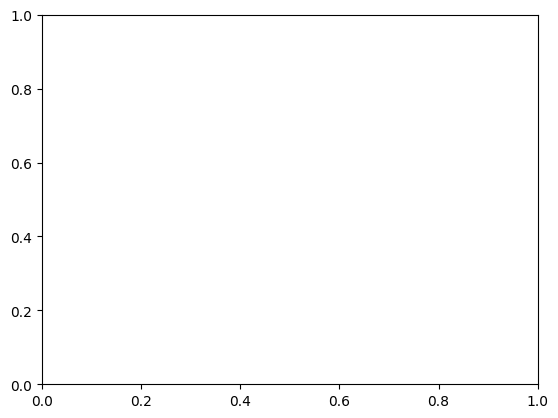

In [19]:
import matplotlib.pyplot as plt
from IPython import display

# Training hyperparameters
max_iters = 5000
base_lr = 3e-4
max_lr = 3e-4
min_lr = 3e-5
use_linear=True
use_cosine=False
warmup_steps = 100
batch_size = 32
block_size = 64

np.seterr(all='ignore')

# Plotting Initialization
step_plot_losses = []
plot_losses = []
fig, ax = plt.subplots()


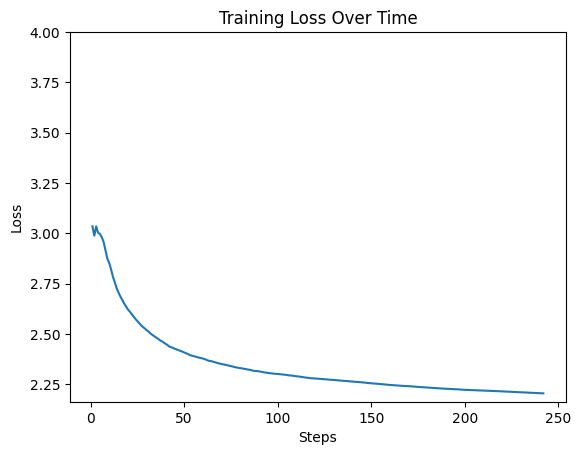

In [ ]:
print("Training model")
# Training loop
for step in range(max_iters):

    if step < warmup_steps:
        # Linear warmup (same for all schedules)
        current_lr = max_lr * (step + 1) / warmup_steps
    else:
        if use_cosine:
            
            # Cosine decay
            decay_ratio = (step - warmup_steps) / (max_iters - warmup_steps)
            cosine_output = 0.5 * (1 + np.cos(np.pi * decay_ratio))
            current_lr = min_lr + (max_lr - min_lr) * cosine_output
        elif use_linear:
            
            # Linear decay
            decay_ratio = (step - warmup_steps) / (max_iters - warmup_steps)
            current_lr = max_lr - (max_lr - min_lr) * decay_ratio
        else:
            # Constant learning rate
            current_lr = base_lr
        
        decay_ratio = (step - warmup_steps) / (max_iters - warmup_steps)
        current_lr = max_lr - (max_lr - min_lr) * decay_ratio        
        
    # Get a mini-batch of data
    x_batch, y_batch = get_batch(data, batch_size, block_size)
    
    # Calculate loss and probabilites
    logits = model.forward(x_batch)
    loss_initial, probabilities = model.calc_loss(logits, y_batch)

    plot_losses.append(loss_initial)


    # Backward Pass
    one_hot_array = np.eye(len(chars))[y_batch]
    initial_gradient = probabilities - one_hot_array
    
    model.backward(initial_gradient)

    # Optimizer
    model.optimizer(current_lr)

    if step % 5 == 0:
        
        step_plot_losses.append(np.mean(plot_losses[-1-step:-1]))
        
        print(f"Step {step}, Loss: {loss_initial}")
        
        # Graph plot
        display.clear_output(wait=True)
        ax.clear()
        ax.plot(step_plot_losses)
        ax.set_title("Training Loss Over Time")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Loss")
        if step_plot_losses[-1] < 4:
            if loss_initial < 2:
                ax.set_ylim(top=2) # cut off loses higher than 2
            else:
                ax.set_ylim(top=4) # cut off loses higher than 4
        display.display(fig)

# Final clear to show the last plot cleanly
display.clear_output(wait=True)
ax.clear()
ax.plot(step_plot_losses)
ax.set_title("Final Training Loss")
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

print(f"Model loss: {model.loss}")

In [ ]:
generate_text("def", 1.0, True, 100)

In [ ]:

# After training, collect LoRA weights
lora_weights = {}

for transformer_idx, transformer in enumerate(model.transformers):
    for head_idx, head in enumerate(transformer.multi_head_attention_block.heads):
        
        # Check if it's a LoRA layer and collect A and B matrices
        if hasattr(head.W_query, 'lora_A'):
            lora_weights[f"transform.{transformer_idx}.head.{head_idx}.query.lora_A"] = head.W_query.lora_A.data
            lora_weights[f"transform.{transformer_idx}.head.{head_idx}.query.lora_B"] = head.W_query.lora_B.data
            
        if hasattr(head.W_value, 'lora_A'):
            lora_weights[f"transform.{transformer_idx}.head.{head_idx}.value.lora_A"] = head.W_value.lora_A.data
            lora_weights[f"transform.{transformer_idx}.head.{head_idx}.value.lora_B"] = head.W_value.lora_B.data

# Save the LoRA weights
np.savez_compressed('../models/lora_weights.npz', **lora_weights)